In [55]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from kneed import KneeLocator
import seaborn as sns

from ucimlrepo import fetch_ucirepo
air_quality = fetch_ucirepo(id=360) 

# X = air_quality.data.features

vars_df = pd.DataFrame(air_quality.variables)
pd.set_option('display.max_colwidth', 200)

#drop useless columns
vars_df = vars_df.drop(columns=['demographic', 'missing_values'], errors='ignore')

display(vars_df.style.set_properties(subset=['description'], **{'text-align': 'left'}))

df = pd.DataFrame(air_quality.data.features)
df.head()

,name,role,type,description,units
0,Date,Feature,Date,None,None
1,Time,Feature,Categorical,None,None
2,CO(GT),Feature,Integer,True hourly averaged concentration CO in mg/m^3 (reference analyzer),mg/m^3
3,PT08.S1(CO),Feature,Categorical,hourly averaged sensor response (nominally CO targeted),None
4,NMHC(GT),Feature,Integer,True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer),microg/m^3
5,C6H6(GT),Feature,Continuous,True hourly averaged Benzene concentration in microg/m^3 (reference analyzer),microg/m^3
6,PT08.S2(NMHC),Feature,Categorical,hourly averaged sensor response (nominally NMHC targeted),None
7,NOx(GT),Feature,Integer,True hourly averaged NOx concentration in ppb (reference analyzer),ppb
8,PT08.S3(NOx),Feature,Categorical,hourly averaged sensor response (nominally NOx targeted),None
9,NO2(GT),Feature,Integer,True hourly averaged NO2 concentration in microg/m^3 (reference analyzer),microg/m^3


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


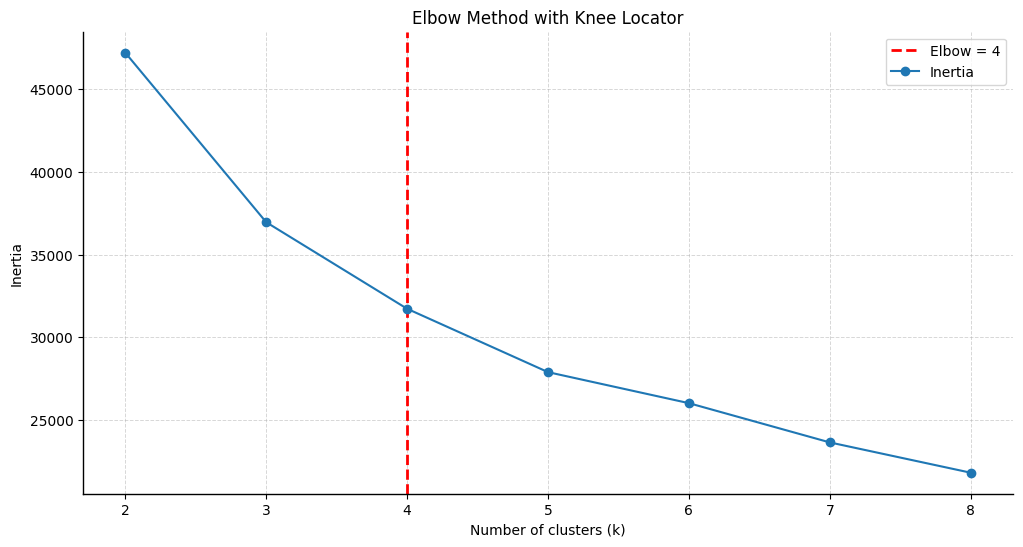

In [57]:
# Select relevant features and clean data
features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 
            'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
X = df[features]
X = X.replace(-200, np.nan).dropna()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute inertia for k values from 2 to 8
K_values = range(2, 9)
inertias = []
for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Identify and plot the elbow point
kneedle = KneeLocator(K_values, inertias, curve='convex', direction='decreasing')
knee_point = kneedle.elbow
plt.figure(figsize=(12, 6))
plt.axvline(x=knee_point, color='red', linestyle='--', linewidth=2, label=f'Elbow = {knee_point}')
plt.plot(K_values, inertias, marker='o', linestyle='-', label='Inertia')

# Customize plot appearance
plt.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.5)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Add labels and title
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method with Knee Locator')
plt.xticks(K_values)
plt.legend()
plt.grid(True)
plt.show()

In [42]:
from sklearn.metrics import silhouette_score

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}, silhouette={score:.3f}")

k=2, silhouette=0.292
k=3, silhouette=0.263
k=4, silhouette=0.243
k=5, silhouette=0.235
k=6, silhouette=0.211
k=7, silhouette=0.220
k=8, silhouette=0.215
k=9, silhouette=0.216


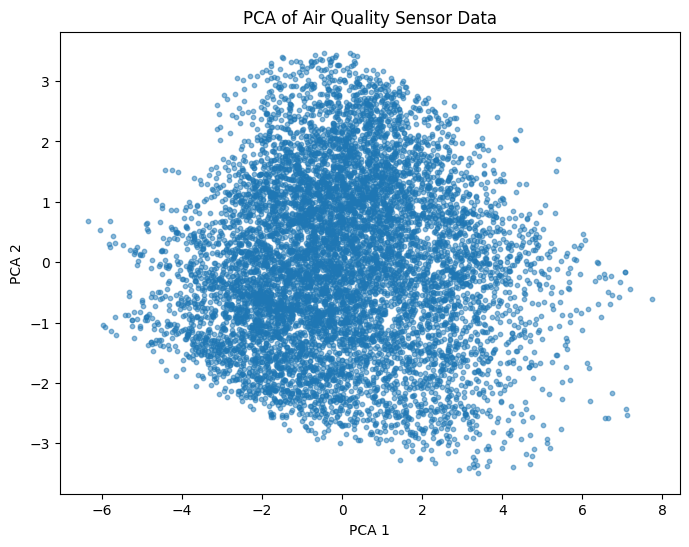

In [25]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Air Quality Sensor Data')
plt.show()



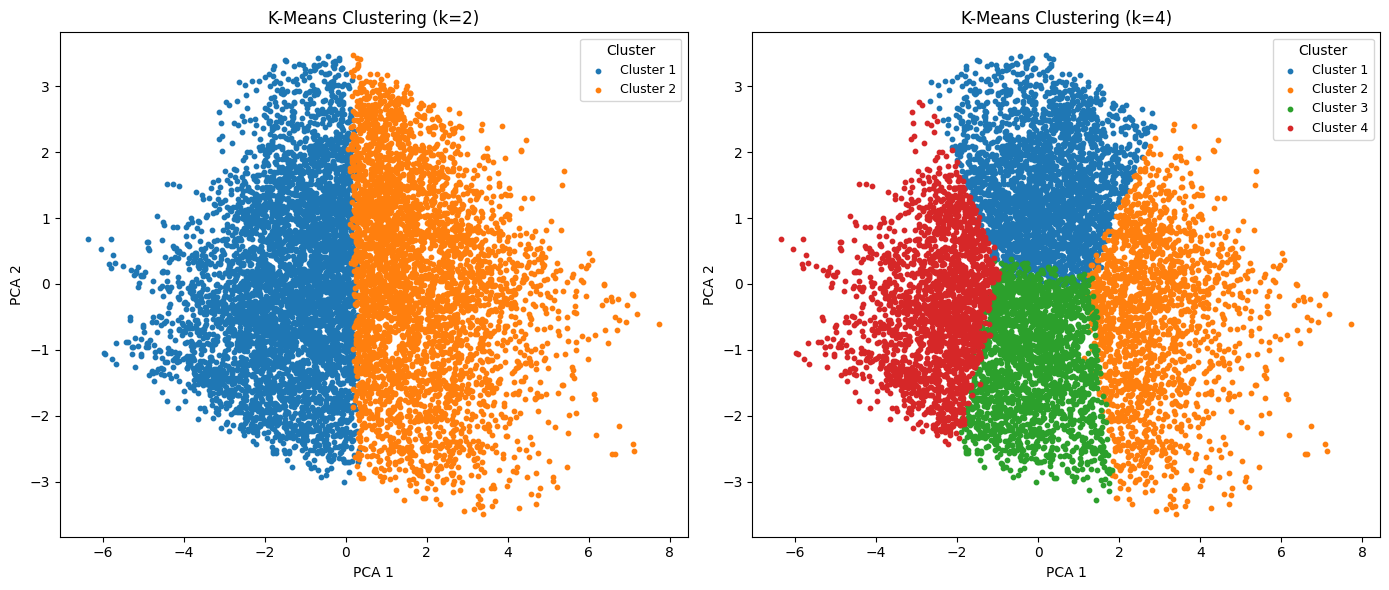

In [26]:
kmeans2 = KMeans(n_clusters=2, random_state=42)
labels2 = kmeans2.fit_predict(X_scaled)

kmeans4 = KMeans(n_clusters=4, random_state=42)
labels4 = kmeans4.fit_predict(X_scaled)

# --- Color palettes ---
colors2 = plt.cm.tab10(np.arange(2))
colors4 = plt.cm.tab10(np.arange(4))

# --- Create side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ===== Left: k=2 =====
for i, color in zip(range(2), colors2):
    axes[0].scatter(
    X_pca[labels2 == i, 0],
    X_pca[labels2 == i, 1],
    s=10, color=color, label=f'Cluster {i+1}'
    )
axes[0].set_title('K-Means Clustering (k=2)')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')
axes[0].legend(title='Cluster', loc='best', fontsize=9)

# ===== Right: k=4 =====
for i, color in zip(range(4), colors4):
    axes[1].scatter(
        X_pca[labels4 == i, 0],
        X_pca[labels4 == i, 1],
        s=10, color=color, label=f'Cluster {i+1}'
    )
axes[1].set_title('K-Means Clustering (k=4)')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')
axes[1].legend(title='Cluster', loc='best', fontsize=9)

plt.tight_layout()
plt.show()

In [43]:
df_clean = X.copy()  # already cleaned & scaled before
df_clean['cluster'] = labels4  # use the cluster labels from k=4
cluster_summary = df_clean.groupby('cluster').mean()
cluster_summary

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
cluster,,,,,,,,
0,1035.398790,922.311989,838.300605,1576.248310,889.317681,27.353184,38.249235,1.300006
1,1420.630553,1322.315818,564.237811,1867.505417,1586.476706,19.300325,52.598104,1.160326
2,1124.365349,923.358915,756.231618,1308.049173,1109.255515,11.754779,59.238419,0.835659
3,884.611214,649.251622,1143.798424,1097.641798,627.757646,12.325765,50.577943,0.744147


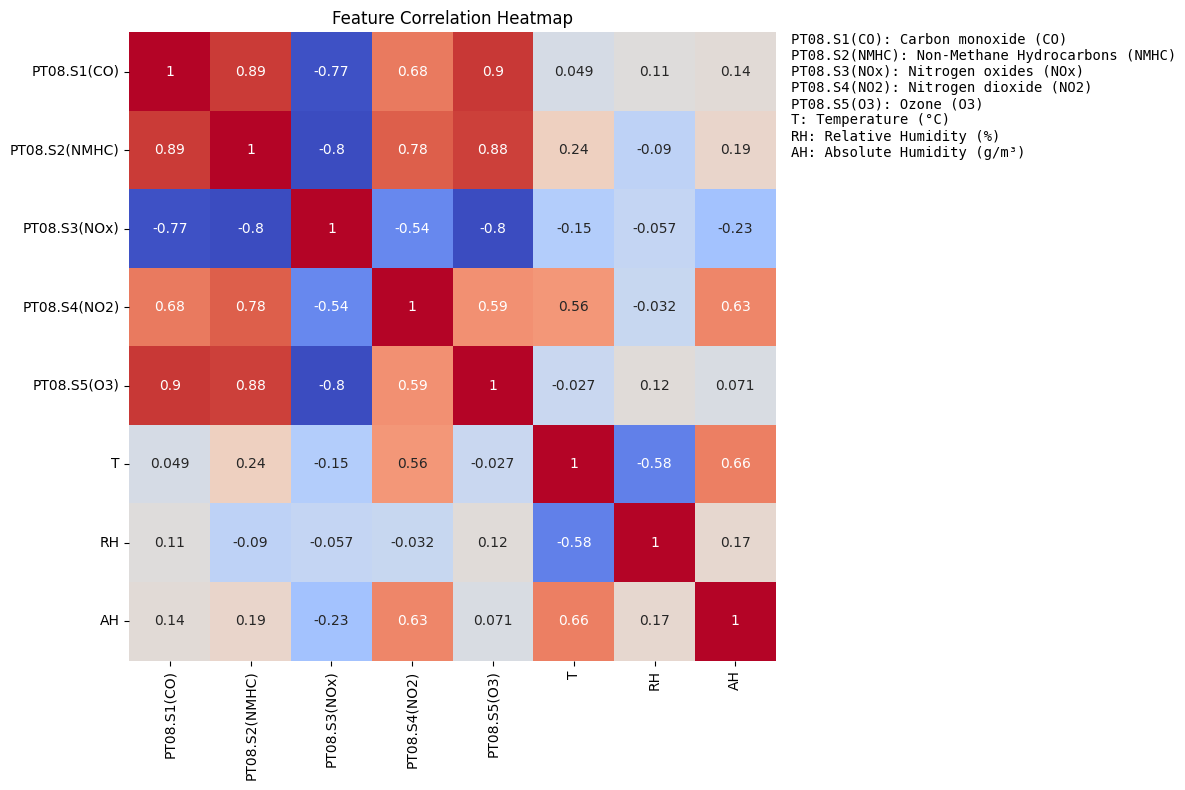

In [66]:
corr = df[features].replace(-200, np.nan).corr()

fig, (ax_hm, ax_leg) = plt.subplots(1, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [3, 1]})

# show full heatmap (no mask)
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax_hm, cbar=False)
ax_hm.set_title('Feature Correlation Heatmap')

label_map = {
    'PT08.S1(CO)': 'Carbon monoxide (CO)',
    'PT08.S2(NMHC)': 'Non‑Methane Hydrocarbons (NMHC)',
    'PT08.S3(NOx)': 'Nitrogen oxides (NOx)',
    'PT08.S4(NO2)': 'Nitrogen dioxide (NO2)',
    'PT08.S5(O3)': 'Ozone (O3)',
    'T': 'Temperature (°C)',
    'RH': 'Relative Humidity (%)',
    'AH': 'Absolute Humidity (g/m³)'
}

ax_leg.axis('off')
legend_text = "\n".join([f"{k}: {v}" for k, v in label_map.items()])
ax_leg.text(0, 1, legend_text, va='top', ha='left', fontsize=10, family='monospace')

plt.tight_layout()
plt.show()